In [1]:
# Environment setup; succesful loading here should mean all dependencies correctly installed #
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata

from scipy import sparse, stats
from scipy.cluster.hierarchy import dendrogram

import seaborn as sbn
import matplotlib.pyplot as plt

from gprofiler import GProfiler

from natsort import natsorted
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import sparsefuncs, issparse
from sklearn.decomposition import PCA

from pathlib import Path


In [2]:
pbmc_gr5 = sc.read_h5ad("data/SUBSET_DATA.h5ad")
pbmc_gr5

AnnData object with n_obs × n_vars = 15775 × 32738
    obs: 'cell-types'
    var: 'gene_ids'

In [193]:
pbmc_gr5.obs['cell-types'].value_counts()

CD56+ NK                      5859
CD19+ B                       3817
CD14+ Monocyte                3306
CD4+/CD45RA+/CD25- Naive T    2793
Name: cell-types, dtype: int64

In [192]:
### QC METRICS RAW DATA ###
qc_pbmc = sc.pp.calculate_qc_metrics(pbmc_gr5,percent_top=None) #Qc metrics of orginal data
qc_pbmc

(                  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
 AAACATACTAACCG-1                349                 5.857933         854.0   
 AAACGCTGGCTAAC-1                550                 6.311735        1101.0   
 AAACTTGACCTAAG-1                727                 6.590301        1417.0   
 AAAGACGAAGTCGT-1                682                 6.526495        1250.0   
 AAAGACGACCCTTG-1                468                 6.150603         927.0   
 ...                             ...                      ...           ...   
 TTTCACGATCGCTC-8                555                 6.320768        1231.0   
 TTTCAGTGCCTTTA-8                532                 6.278521        1281.0   
 TTTCTACTCGAATC-8                593                 6.386879        1405.0   
 TTTGACTGCTTTAC-8                523                 6.261492        1247.0   
 TTTGACTGTCGTTT-8                578                 6.361302        1579.0   
 
                   log1p_total_counts  
 AAACATACT

C:\Users\linhn\AppData\Local\Temp\ipykernel_32724\1013649523.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(qc_pbmc[0]['total_counts'], color = 'blue') #log10 total read counts per cell
C:\Users\linhn\AppData\Local\Temp\ipykernel_32724\1013649523.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.d

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

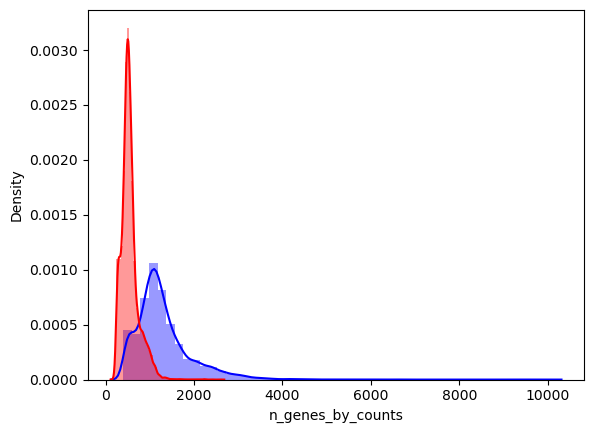

In [103]:
#distribution of read count and gene expression
sbn.distplot(qc_pbmc[0]['total_counts'], color = 'blue') #log10 total read counts per cell
sbn.distplot(qc_pbmc[0]['n_genes_by_counts'], color = 'red') #log 10 total gene per cell

Expectation of more read count -> more genes counts -> distrbution have the same shape\

the distribution of read count and genes counts -> outliers/ error

# GENE LEVEL FILTERING 
## Filter gene count = 0 all cells

In [104]:
sc.pp.filter_genes(pbmc_gr5, min_counts=1, inplace=True) # keep genes having a least count = 1 
pbmc_gr5

AnnData object with n_obs × n_vars = 15674 × 14201
    obs: 'cell-types', 'percent_mito', 'total_genes_per_cell'
    var: 'gene_ids', 'n_counts', 'n_cells', 'mt_genes'

## Filter genes with expression less than 5 cells

In [105]:
sc.pp.filter_genes(pbmc_gr5, min_cells=5, inplace=True) # keep genes express in at lease 5 cells
pbmc_gr5

AnnData object with n_obs × n_vars = 15674 × 14191
    obs: 'cell-types', 'percent_mito', 'total_genes_per_cell'
    var: 'gene_ids', 'n_counts', 'n_cells', 'mt_genes'

In [106]:
print("Filter out: ", 32738 - 14201)

Filter out:  18537


### Cell metric

In [107]:
cell_metrics = pd.DataFrame(index = pbmc_gr5.obs_names)

total_genes_express = qc_pbmc[0]['n_genes_by_counts'] #original data
total_counts = qc_pbmc[0]['total_counts'] #OG data

cell_metrics['Total genes expressing each cell'] = total_genes_express
cell_metrics['Total counts each cell'] = total_counts

# Cell level filtering
## Filter cells with mito count > 5%

In [108]:
print("Total Mt genes ", sum(pbmc_gr5.var_names.str.startswith('MT-'))) # Number of mitochondrial genes

Total Mt genes  13


In [109]:
#noting mt genes
pbmc_gr5.var['mt_genes'] = pbmc_gr5.var_names.str.startswith('MT-')

mito_gene = list(pbmc_gr5.var.loc[pbmc_gr5.var['mt_genes']==True].index)

mito_pbmc = pbmc_gr5[:, mito_gene]
mito_pbmc
mito_metrics = sc.pp.calculate_qc_metrics(mito_pbmc, percent_top=None, inplace=False)

cell_metrics['Total reads mito genes'] = mito_metrics[0]['total_counts']
cell_metrics['Pct mito reads'] = round(cell_metrics['Total reads mito genes']/cell_metrics['Total counts each cell']*100, 2)

In [110]:
(cell_metrics['Pct mito reads'] >= 5).value_counts() # 98 cells with %mito gene reads more than 5% -> filter out these cells

False    15674
Name: Pct mito reads, dtype: int64

In [111]:
pbmc_gr5.obs['percent_mito'] = cell_metrics['Pct mito reads'] #add pct of mito reads in obs

pbmc_gr5 = pbmc_gr5[pbmc_gr5.obs['percent_mito'] < 5, :] # subset pbmc with cells having mito reads less than 5%
pbmc_gr5

View of AnnData object with n_obs × n_vars = 15674 × 14191
    obs: 'cell-types', 'percent_mito', 'total_genes_per_cell'
    var: 'gene_ids', 'n_counts', 'n_cells', 'mt_genes'

In [112]:
print("Filter out: ", cell_metrics.shape[0] - pbmc_gr5.obs.shape[0])

Filter out:  0


## Filter cells with outlier number of expression genes 

In [113]:
cell_types = np.array(pbmc_gr5.obs['cell-types'])
cell_types = np.unique(cell_types)
cell_types

array(['CD14+ Monocyte', 'CD19+ B', 'CD4+/CD45RA+/CD25- Naive T',
       'CD56+ NK'], dtype=object)

C:\Users\linhn\AppData\Local\Temp\ipykernel_32724\3417671257.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pbmc_gr5.obs['total_genes_per_cell'] = cell_metrics['Total genes expressing each cell']
C:\Users\linhn\AppData\Local\Temp\ipykernel_32724\3417671257.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(pbmc_gr5.obs.total_genes_per_cell)


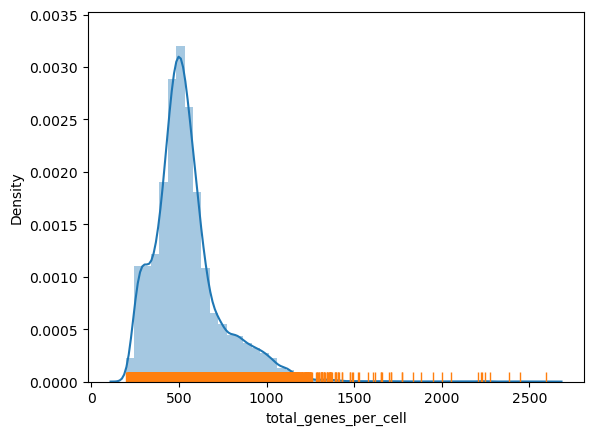

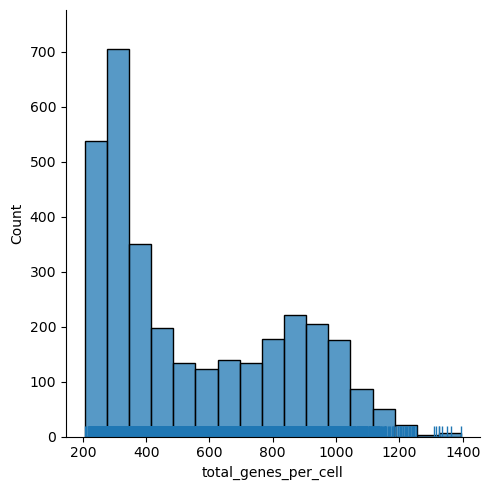

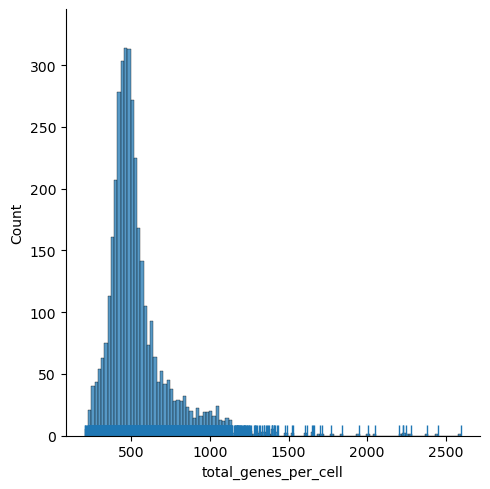

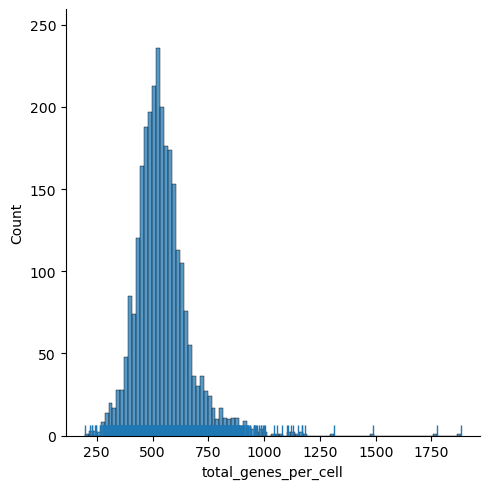

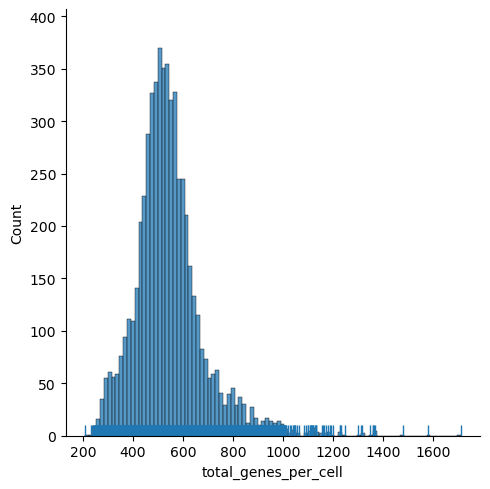

In [114]:
#visualize the total genes per cell 
pbmc_gr5.obs['total_genes_per_cell'] = cell_metrics['Total genes expressing each cell']

sbn.distplot(pbmc_gr5.obs.total_genes_per_cell)
sbn.rugplot(pbmc_gr5.obs.total_genes_per_cell)

for cell in cell_types:
    sbn.displot(pbmc_gr5[pbmc_gr5.obs['cell-types']==cell, :].obs.total_genes_per_cell)
    sbn.rugplot(pbmc_gr5[pbmc_gr5.obs['cell-types']==cell, :].obs.total_genes_per_cell)
    


From the plot of #gene distribution -> # gene ranging for unsorted 250-1000 while in each type can up to 1k6-2k genes -> a few outlier

### Trying to remove with recommended +-3MAD

238.0 790.0
Number of cells after filtering cells:  13823


C:\Users\linhn\AppData\Local\Temp\ipykernel_32724\1186647168.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(pbmc_filtered.obs.total_genes_per_cell)


<AxesSubplot:xlabel='total_genes_per_cell', ylabel='Density'>

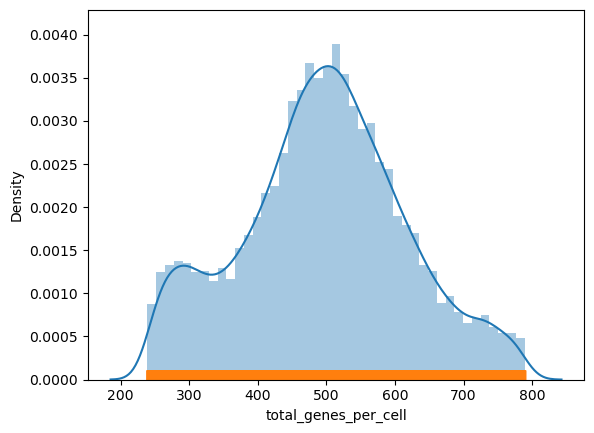

In [115]:
n_gene_per_cells = pbmc_gr5.X.getnnz(axis=1) #number of genes per cells
MAD = np.median(abs(n_gene_per_cells - np.median(n_gene_per_cells))) # MAD
lower_bound = np.median(n_gene_per_cells) - 3*MAD 
upper_bound = np.median(n_gene_per_cells) + 3*MAD

print(lower_bound, upper_bound)

pbmc_filtered = pbmc_gr5[pbmc_gr5.obs.total_genes_per_cell > lower_bound, :]
pbmc_filtered = pbmc_filtered[pbmc_filtered.obs.total_genes_per_cell < upper_bound, :]
print('Number of cells after filtering cells: ', pbmc_filtered.shape[0])

# Check the effect of data preprocessing, notice the change to the normal distribution 
sbn.distplot(pbmc_filtered.obs.total_genes_per_cell)
sbn.rugplot(pbmc_filtered.obs.total_genes_per_cell)

In [116]:
pbmc_filtered

View of AnnData object with n_obs × n_vars = 13823 × 14191
    obs: 'cell-types', 'percent_mito', 'total_genes_per_cell'
    var: 'gene_ids', 'n_counts', 'n_cells', 'mt_genes'

In [117]:
pbmc_filtered.raw = pbmc_filtered

# Normalization

By median of total library size.

In [118]:
qc_filter = sc.pp.calculate_qc_metrics(pbmc_filtered, inplace = False, percent_top=None, log1p=False)
mean_lib = np.median(qc_filter[0]['total_counts'])
qc_filter[0].describe()
 

,n_genes_by_counts,total_counts
count,13823.000000,13823.000000
mean,495.330030,1131.341675
std,120.811898,381.800995
min,239.000000,402.000000
25%,419.000000,880.000000
50%,498.000000,1110.000000
75%,573.000000,1359.000000
max,789.000000,2573.000000


In [119]:
pbmc_filtered.layers['orginial_counts'] = pbmc_filtered.X.copy()
sc.pp.normalize_total(pbmc_filtered, target_sum=mean_lib)

In [161]:
print(pbmc_filtered.X)

  (0, 80)	1.2997658
  (0, 92)	1.2997658
  (0, 104)	1.2997658
  (0, 217)	1.2997658
  (0, 232)	18.196722
  (0, 267)	1.2997658
  (0, 275)	3.8992975
  (0, 326)	1.2997658
  (0, 381)	1.2997658
  (0, 432)	1.2997658
  (0, 484)	5.1990633
  (0, 539)	1.2997658
  (0, 601)	2.5995317
  (0, 677)	2.5995317
  (0, 769)	1.2997658
  (0, 772)	1.2997658
  (0, 800)	1.2997658
  (0, 841)	1.2997658
  (0, 844)	1.2997658
  (0, 947)	1.2997658
  (0, 949)	1.2997658
  (0, 960)	1.2997658
  (0, 966)	2.5995317
  (0, 1000)	1.2997658
  (0, 1035)	1.2997658
  :	:
  (13822, 13714)	0.7029766
  (13822, 13723)	1.4059532
  (13822, 13724)	0.7029766
  (13822, 13739)	0.7029766
  (13822, 13774)	0.7029766
  (13822, 13784)	1.4059532
  (13822, 13800)	0.7029766
  (13822, 13814)	0.7029766
  (13822, 13817)	0.7029766
  (13822, 13820)	0.7029766
  (13822, 13856)	0.7029766
  (13822, 13899)	16.871437
  (13822, 13943)	0.7029766
  (13822, 13960)	0.7029766
  (13822, 13994)	0.7029766
  (13822, 14010)	0.7029766
  (13822, 14096)	0.7029766
  (13822, 

Text(0.5, 1.0, 'Total counts distribution')

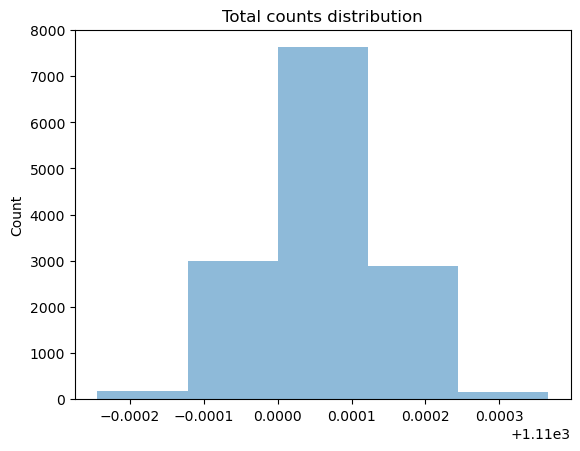

In [122]:
sbn.histplot(pbmc_filtered.X.sum(axis=1), discrete=False, legend=False, color='red')
plt.title('Total counts distribution')

Text(0.5, 1.0, 'Before normalisation')

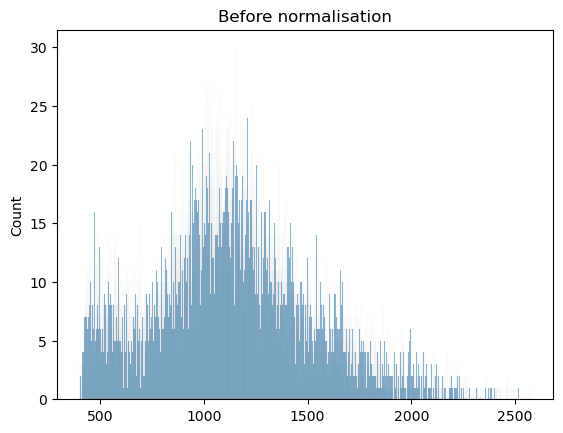

In [125]:
# You can restore the value before normalisation 
sbn.histplot(pbmc_filtered.layers['orginial_counts'].sum(axis=1), discrete=True, legend=False)
plt.title('Before normalisation')

In [42]:
#annotations
cell_annotations = pd.DataFrame(pbmc_filtered.obs['cell-types'])
cell_annotations.value_counts('cell-types') #4 cells types

cell-types
CD56+ NK                      5479
CD19+ B                       3370
CD4+/CD45RA+/CD25- Naive T    2672
CD14+ Monocyte                2300
dtype: int64

In [43]:
#sc.pp.log1p(pbmc_filtered) #log transformation log(X+1)

# Feature selection

Number of highly variable genes selected:  1134


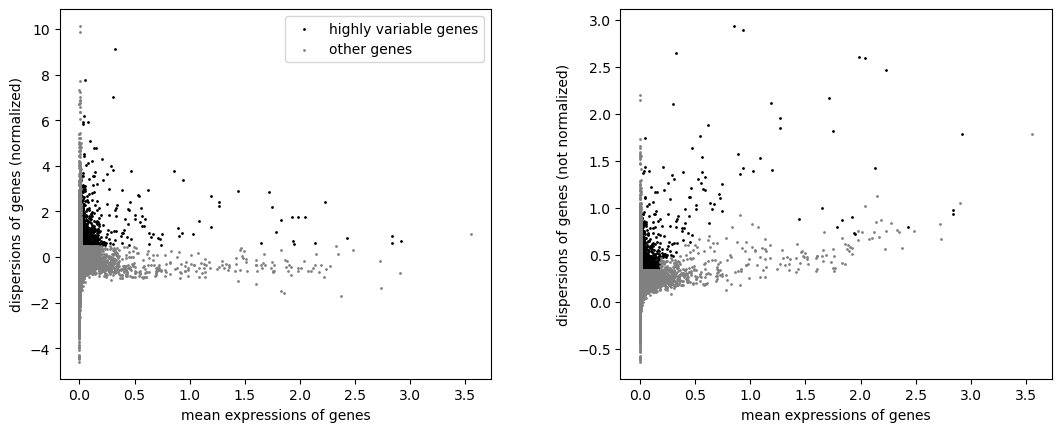

In [44]:
#choosing higher variances genes -> giving more information about differences genes expression each type
sc.pp.highly_variable_genes(pbmc_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5) #standard option
print("Number of highly variable genes selected: ", sum(pbmc_filtered.var['highly_variable'].values))
sc.pl.highly_variable_genes(pbmc_filtered)

In [45]:
high_var_filtered_pbmc = pbmc_filtered[:, pbmc_filtered.var['highly_variable'] == True]

## Dimension reduction

In [46]:
gene_count_scale = sc.pp.scale(high_var_filtered_pbmc, zero_center=True, copy=True).X 

In [141]:
high_var_filtered_pbmc.var_names

Index(['NOC2L', 'HES4', 'ISG15', 'TNFRSF18', 'ACAP3', 'MRPL20', 'NADK',
       'RP3-395M20.12', 'WRAP73', 'ZBTB48',
       ...
       'CBR1', 'NDUFV3', 'PDXK', 'AP001055.6', 'UBE2G2', 'PTTG1IP', 'COL6A2',
       'DIP2A', 'S100B', 'MT-CO1'],
      dtype='object', length=1134)

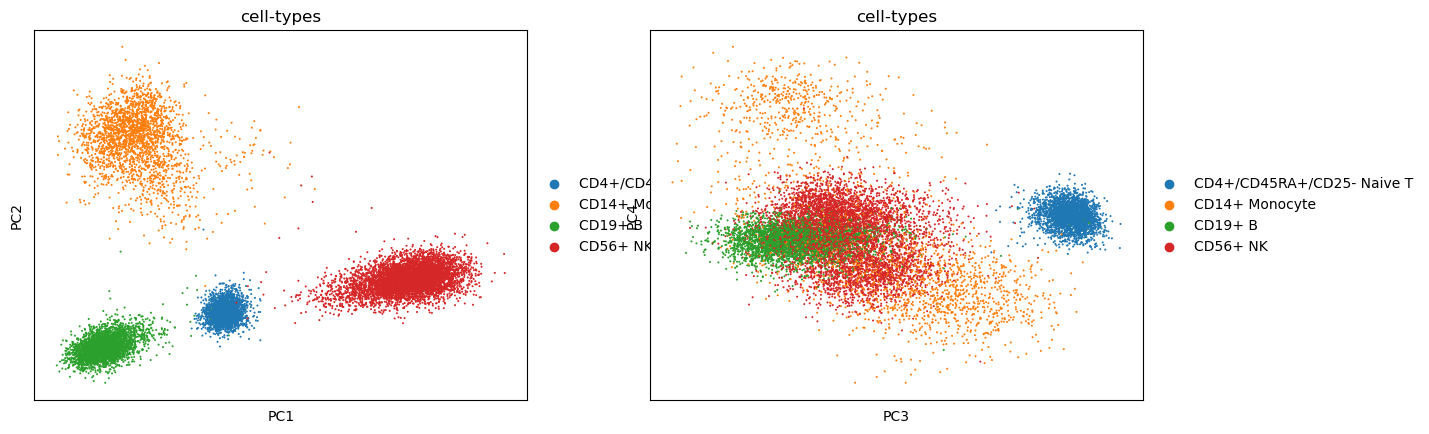

In [47]:
sc.tl.pca(high_var_filtered_pbmc, zero_center=True, svd_solver='arpack')
#plot PCs
sc.pl.pca(high_var_filtered_pbmc, color='cell-types', components = ['1,2','3,4'], ncols=2)

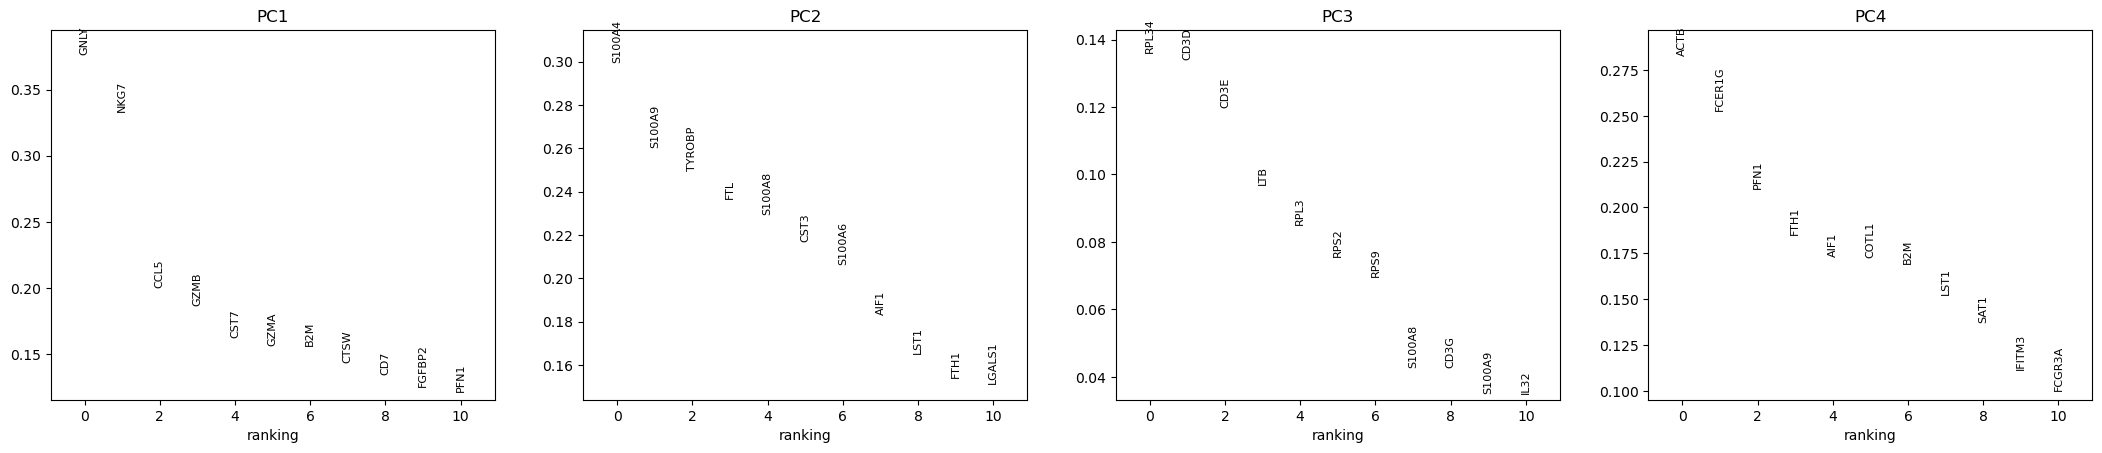

In [127]:
#Plot loadings: ranking genes based on the contribution in each PC
sc.pl.pca_loadings(high_var_filtered_pbmc, components=[1,2,3,4], include_lowest=False, n_points=10)

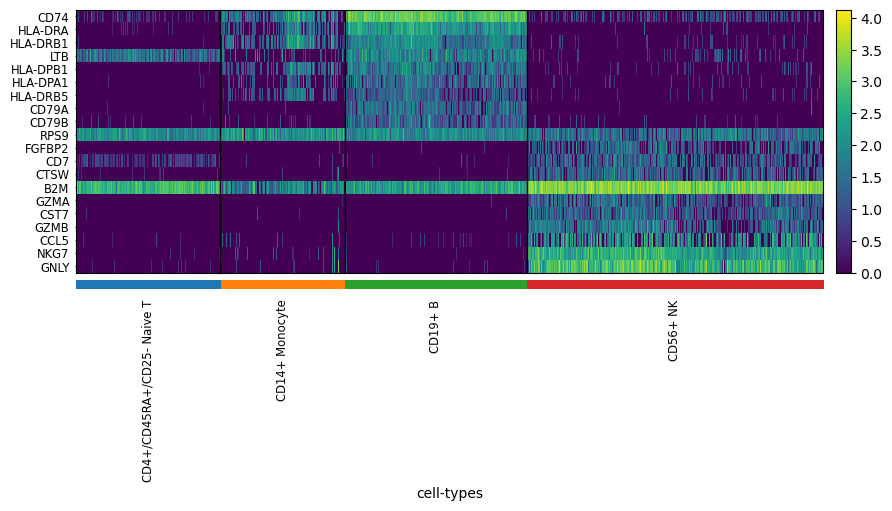

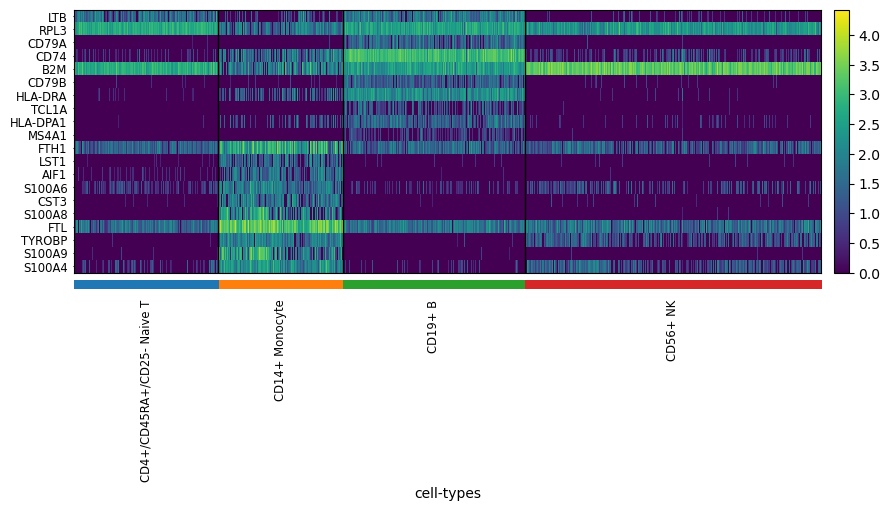

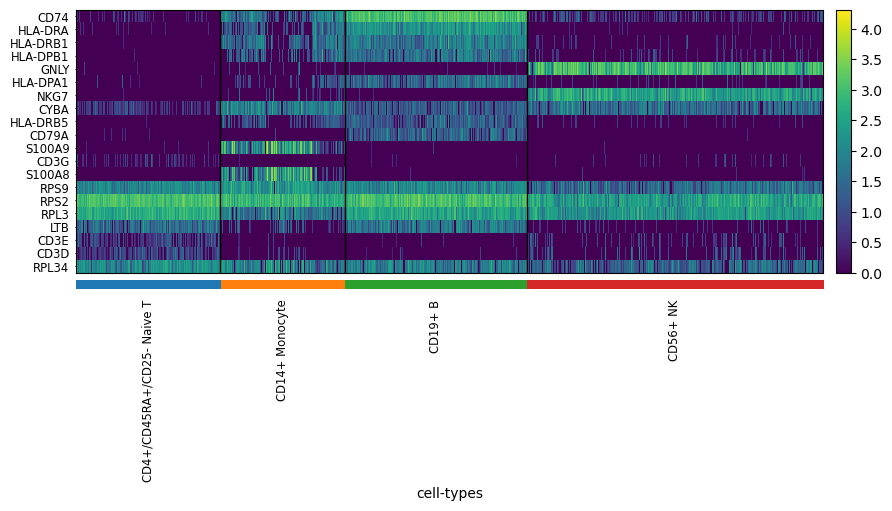

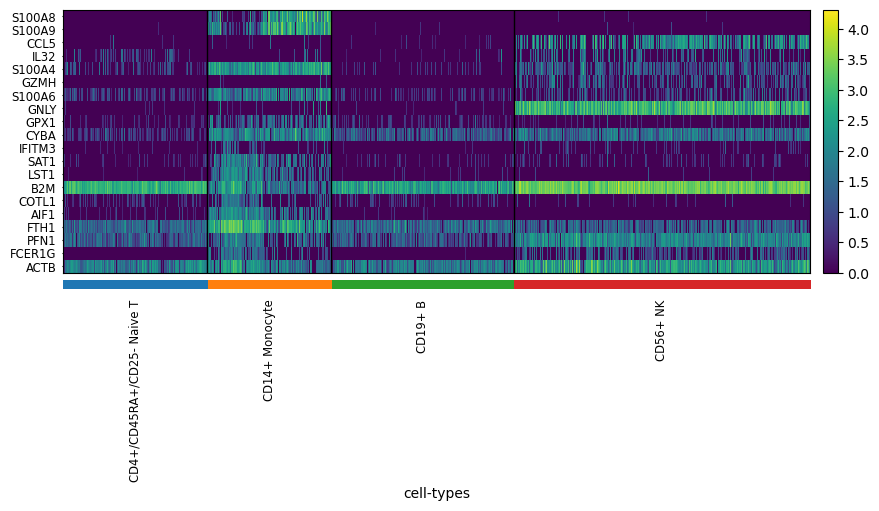

In [49]:
#Visualize top ranked gene and bottom ranked gene
genes = high_var_filtered_pbmc.var['gene_ids']
for pc in [1,2,3,4]:
    g = high_var_filtered_pbmc.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = high_var_filtered_pbmc.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = high_var_filtered_pbmc[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby='cell-types', swap_axes = True, use_raw=False)

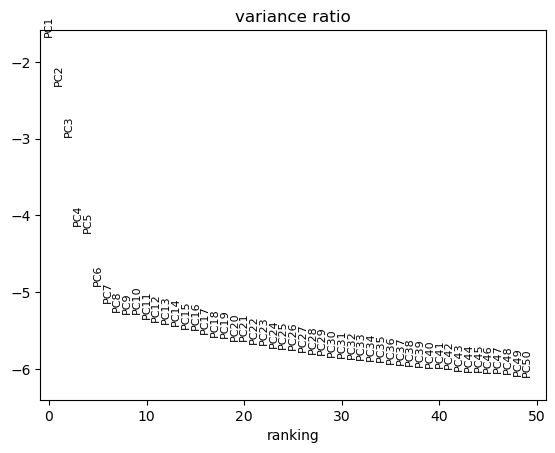

In [50]:
#the amount of variance explained in each PC
sc.pl.pca_variance_ratio(high_var_filtered_pbmc,log=True, n_pcs = 50)

Until PC4-5 contains most of the information. We can indude more PC in order to not exclude rare cell variances. (up to PC30)

C:\Users\linhn\anaconda3\envs\binf7000\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


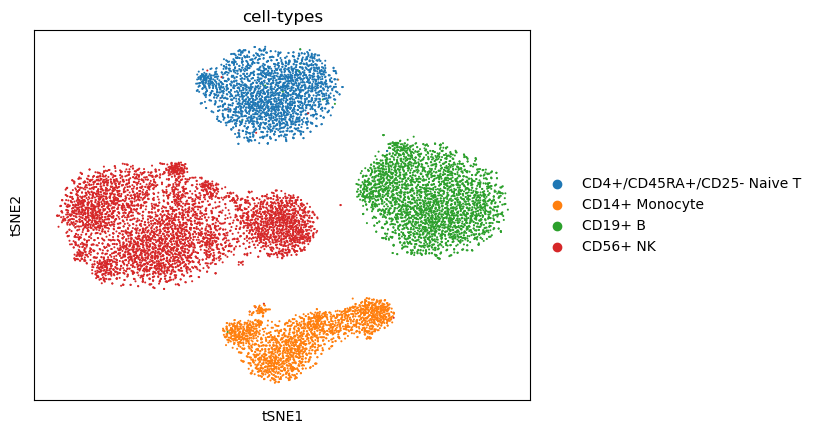

In [51]:
#tsne visualization
sc.tl.tsne(high_var_filtered_pbmc, n_pcs = 30)
sc.pl.tsne(high_var_filtered_pbmc, color='cell-types')

# Clustering 

I. On all high variance genes

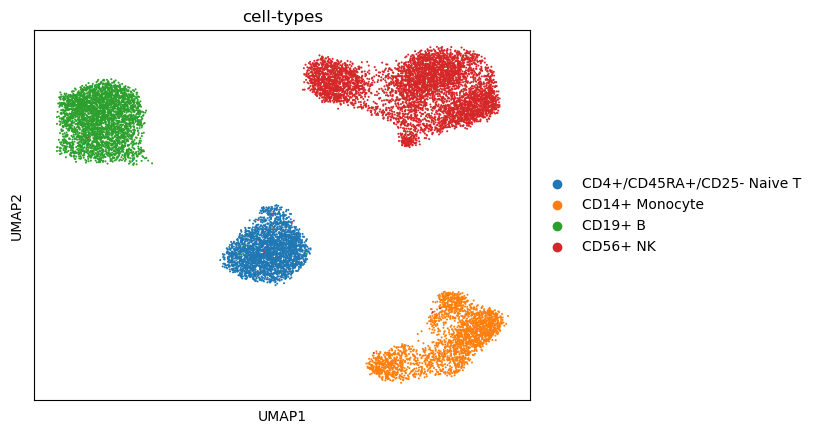

In [70]:
#UMAP 
sc.pp.neighbors(high_var_filtered_pbmc, n_pcs = 30, n_neighbors = 15) #based on pca and neighbor connecting using first 30 PCs 
sc.tl.umap(high_var_filtered_pbmc)
sc.pl.umap(high_var_filtered_pbmc, color='cell-types')

### Kmean 

In [71]:
from sklearn.cluster import KMeans
#pca data
data_pca = high_var_filtered_pbmc.obsm['X_pca']

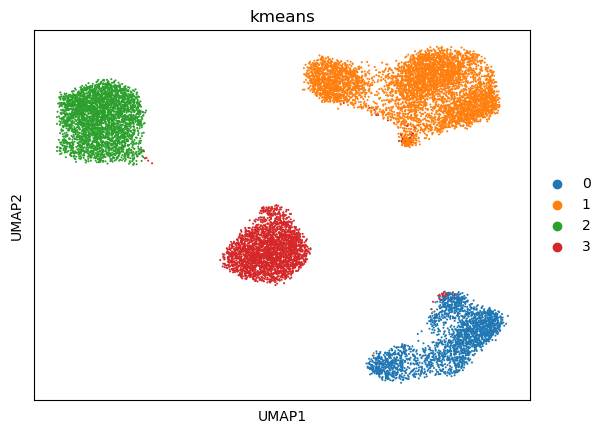

In [76]:
#kmean cluster
kmeans_clust = KMeans(n_clusters = 4).fit(data_pca) 

#cluster annotation
cluster_results_kmeans = pd.Categorical(
        values=np.array(kmeans_clust.labels_).astype('U'),
        categories=natsorted(np.unique(np.array(kmeans_clust.labels_)).astype('U')),
    )

high_var_filtered_pbmc.obs['kmeans'] = cluster_results_kmeans

# UMAP visualisation 
sc.pl.umap(high_var_filtered_pbmc, color=['kmeans'])

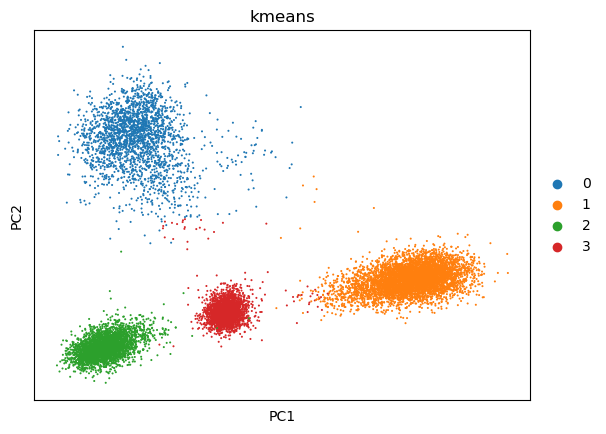

In [77]:
# PCA visualisation 
sc.pl.pca(high_var_filtered_pbmc, color=['kmeans'])

In [78]:
# Number of cells/samples per cluster 
from collections import Counter
Counter(cluster_results_kmeans).items()

dict_items([('2', 3355), ('1', 5450), ('3', 2738), ('0', 2278)])

In [79]:
cell_annotations.value_counts()
# good clustering with like the same number of cells

cell-types                
CD56+ NK                      5479
CD19+ B                       3370
CD4+/CD45RA+/CD25- Naive T    2672
CD14+ Monocyte                2300
dtype: int64

## Some genes of interest and in original paper and gene rank analysis (below)
Enrichment genes in each type:
- NK cell: NKG7, GNLY
- Monocyte: FCGR1G, S100A8, S100A9
- B cell: CD79A, CD79B, FGFBP2
- Native T cell: CD3D, LDHB

In [138]:
markers =["GNLY", "NKG7", "CD79A", "S100A8", "S100A9", "CD79B", "CD3D", "FTL", 'CD74', "LDHB"]

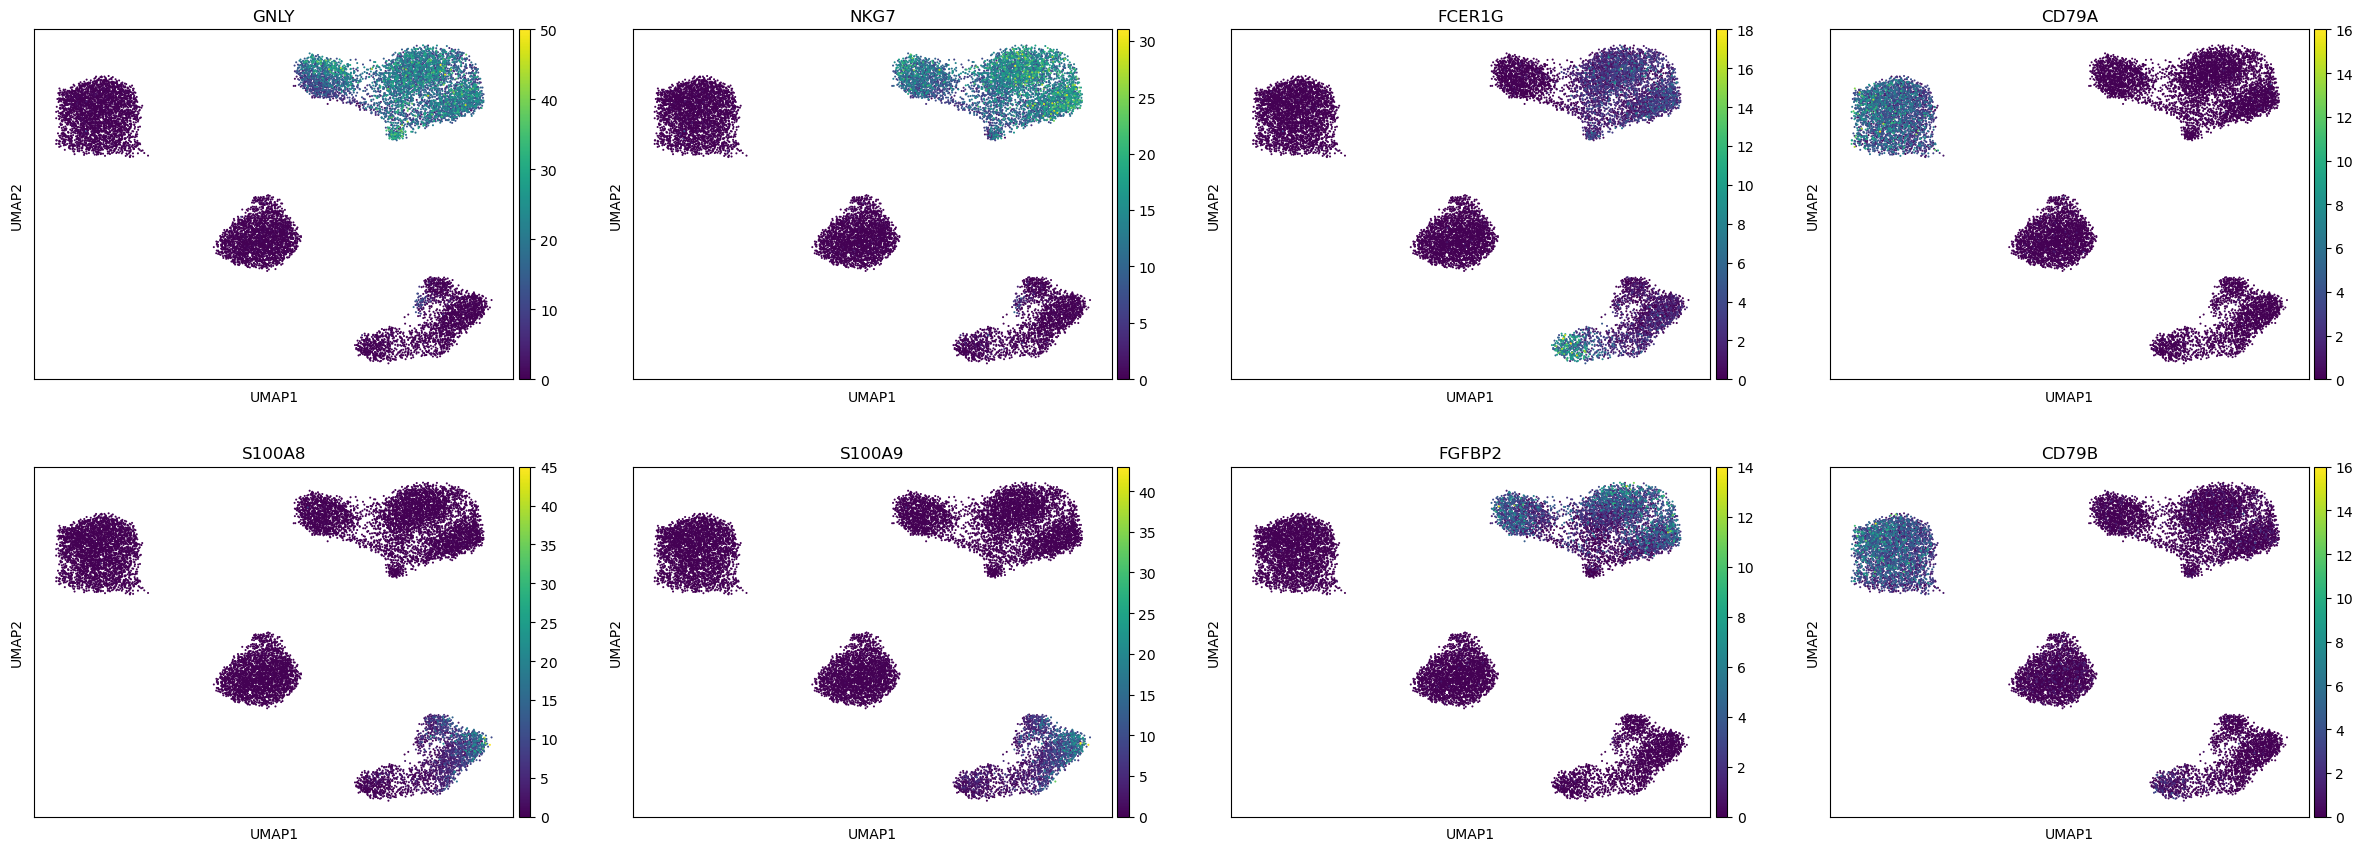

In [84]:
sc.pl.umap(high_var_filtered_pbmc, color = goi)

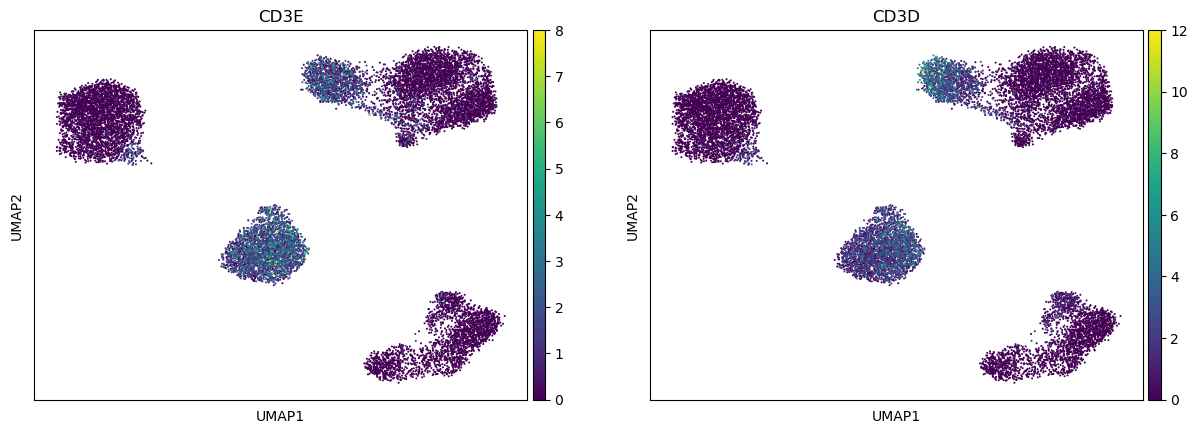

In [85]:
sc.pl.umap(high_var_filtered_pbmc, color = ["CD3E", "CD3D"])
#also express in a part of NK cell population. 

## Marker visualization on entire data set

In [158]:
#orginal_data = sc.read_h5ad('data/Group_5.h5ad')

categories: CD4+/CD45RA+/CD25- Naive T, CD14+ Monocyte, CD19+ B, etc.
var_group_labels: cell-types


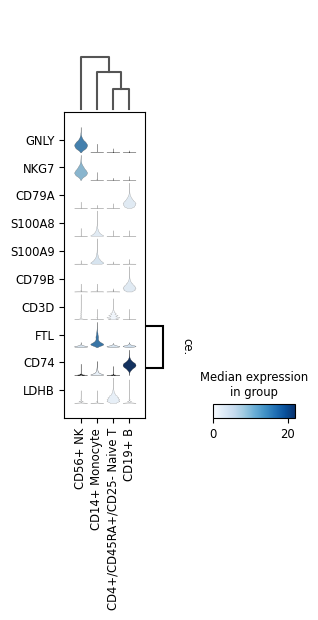

In [196]:
#genes expression
plot1 = sc.pl.stacked_violin(pbmc_filtered, markers, groupby='cell-types', swap_axes=True, use_raw=True,
                         var_group_positions=[(7, 8)], var_group_labels=['cell-types'], dendrogram=True)

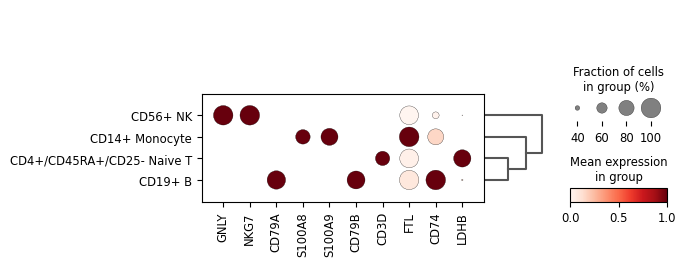

In [143]:
#genes expression and pct cells
plot2 = ax = sc.pl.dotplot(pbmc_filtered, markers, groupby='cell-types', use_raw=True, dendrogram=True, dot_max=1, dot_min=0.3, standard_scale='var')

# Gene ranking in the raw qc data

C:\Users\linhn\anaconda3\envs\binf7000\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


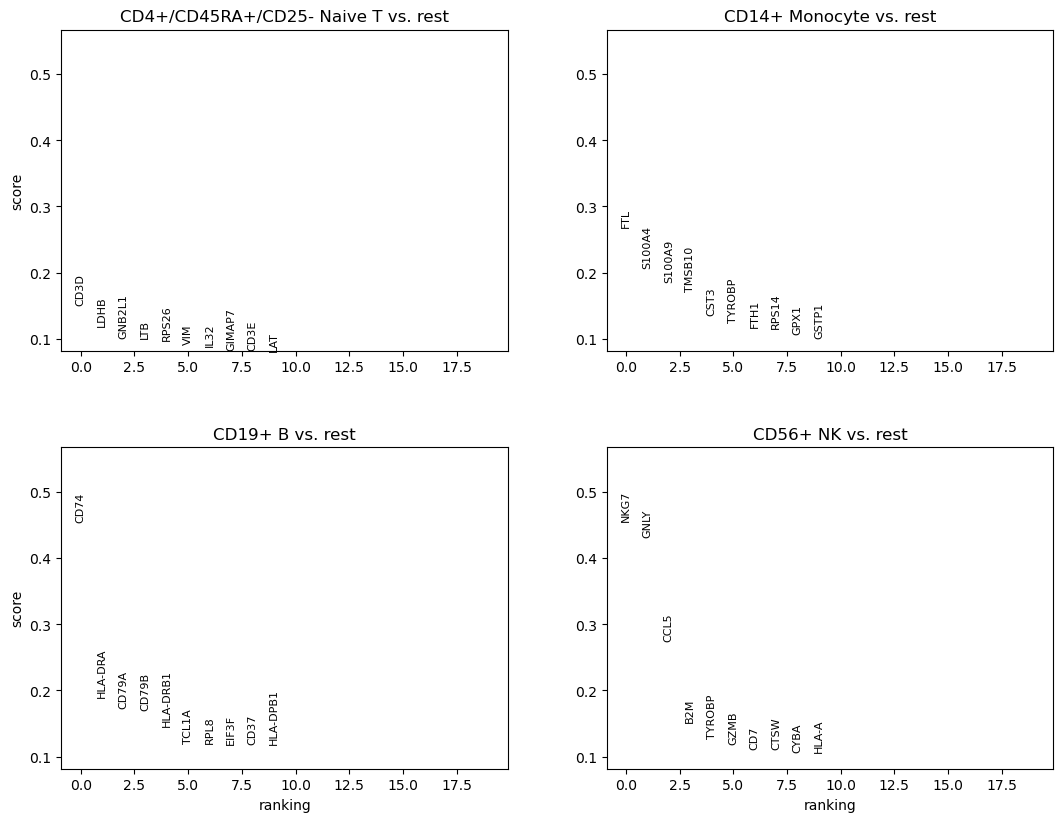

In [148]:
sc.tl.rank_genes_groups(pbmc_filtered, groupby='cell-types', method='logreg', use_raw=True, n_genes=10, key_added="ranking")
sc.pl.rank_genes_groups(pbmc_filtered, ncols=2)

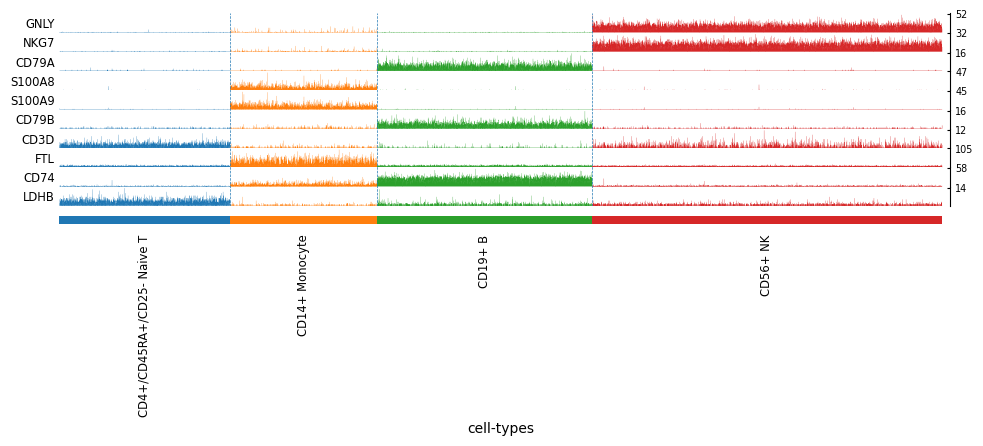

In [141]:
sc.pl.tracksplot(pbmc_filtered,markers, groupby='cell-types', use_raw=True)

In [ ]:
top_rank_gene = list(pbmc_filtered.uns['rank_genes_groups']['names'])
goi = []
for group in top_rank_gene:
    for gene in group:
        goi.append(gene)

In [189]:
pbmc_filtered.write_h5ad("pmbc_after_filter.h5ad")

In [186]:
saved_pbmc = pbmc_filtered[:, goi]
pd_logcount = saved_pbmc.to_df()
pd_logcount.insert(0, "cell_types", saved_pbmc.obs['cell-types'])
pd_rawcount = saved_pbmc.to_df(layer='orginial_counts')
pd_rawcount.insert(0, "cell_types", saved_pbmc.obs['cell-types'])
pd_rawcount

,cell_types,CD3D,FTL,CD74,NKG7,LDHB,S100A4,HLA-DRA,GNLY,GNB2L1,...,EIF3F,CTSW,CD3E,GPX1,CD37,CYBA,LAT,GSTP1,HLA-DPB1,HLA-A
AAACATACTAACCG-1,CD19+ B,0.0,5.0,12.0,0.0,0.0,1.0,4.0,0.0,6.0,...,2.0,1.0,0.0,0.0,7.0,4.0,0.0,0.0,3.0,2.0
AAACGCTGGCTAAC-1,CD56+ NK,3.0,7.0,6.0,8.0,0.0,1.0,1.0,19.0,3.0,...,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,5.0
AAACTTGACCTAAG-1,CD56+ NK,0.0,4.0,0.0,14.0,0.0,3.0,0.0,18.0,3.0,...,0.0,5.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,15.0
AAAGACGAAGTCGT-1,CD56+ NK,0.0,3.0,0.0,11.0,0.0,3.0,0.0,22.0,6.0,...,0.0,4.0,0.0,1.0,1.0,5.0,2.0,2.0,0.0,6.0
AAAGACGACCCTTG-1,CD56+ NK,0.0,4.0,0.0,8.0,0.0,0.0,0.0,17.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCACGATCGCTC-8,CD14+ Monocyte,1.0,12.0,1.0,0.0,1.0,4.0,1.0,0.0,3.0,...,0.0,0.0,1.0,3.0,3.0,6.0,0.0,0.0,0.0,13.0
TTTCAGTGCCTTTA-8,CD4+/CD45RA+/CD25- Naive T,1.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,3.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
TTTCTACTCGAATC-8,CD4+/CD45RA+/CD25- Naive T,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,4.0
TTTGACTGCTTTAC-8,CD4+/CD45RA+/CD25- Naive T,2.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,...,1.0,0.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0


In [187]:
pd_logcount.to_csv("PBMC_top10_ranked_gene_each_type(normalized and logtransform).csv")
pd_rawcount.to_csv("PBMC_top10_ranked_gene_each_type(rawcount).csv")

# Summary 
    1. Raw data processing
    - Filter genes:
        - Genes have count = 0 across all cell samples
        - Genes express in less than 5 cells (to reduce the technical error)
    - Filter cell samples:
        - Percentage of mitochondria reads > 5%
        - Cells with abundance or low number of gene expression using MAD method with bound +/-3*MAD -> discard low quality features capture in cell -> after filter the distribution of read counts and features are like normal distribute
    2. Normalization 
    - by median of total library size across all cells
    - Log transformation of read count
    3. Feature selection and dimemsion reduction
    - Exploring the most highly variable genes: these genes will give the most information about difference of gene expression between different cell types (might expecting genes enrichment in 1 type compared to others)
    - Dimension reduction by PCA -> first 4 PCs containing the majority of explained variances, should expandind the PC in order to capture mixed expression or rare expression cases -> ranking the genes contribution for each PCs (1-4) and visualization through heatmap -> choose potetial features.
    - Try kmean clustering (same as in the paper) to cluster based on the all highly variable genes and on subset of choosen markers and visual on umap of cell types -> good clustering 
    - PCs gene ranking analysis and gene ranking analysis -> to get potential marker
    => save top 10 ranked genes in each cell type.
        

In [ ]:
exp_matrix = 
list cell
list of gene
pd.dataframe(data = expre, index= list cell, columns=list of gene)



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv("PBMC_top10_ranked_gene_each_type(normalized and logtransform).csv",index_col=0)
cell_type = np.array(data.pop("cell_types"))
cell_type

array(['CD19+ B', 'CD56+ NK', 'CD56+ NK', ...,
       'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RA+/CD25- Naive T',
       'CD4+/CD45RA+/CD25- Naive T'], dtype=object)

In [17]:
data.columns

Index(['CD3D', 'FTL', 'CD74', 'NKG7', 'LDHB', 'S100A4', 'HLA-DRA', 'GNLY',
       'GNB2L1', 'S100A9', 'CD79A', 'CCL5', 'LTB', 'TMSB10', 'CD79B', 'B2M',
       'RPS26', 'CST3', 'HLA-DRB1', 'TYROBP', 'VIM', 'TYROBP.1', 'TCL1A',
       'GZMB', 'IL32', 'FTH1', 'RPL8', 'CD7', 'GIMAP7', 'RPS14', 'EIF3F',
       'CTSW', 'CD3E', 'GPX1', 'CD37', 'CYBA', 'LAT', 'GSTP1', 'HLA-DPB1',
       'HLA-A'],
      dtype='object')

In [12]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), data, cell_type, 
                                                        cv=10, scoring='accuracy', n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

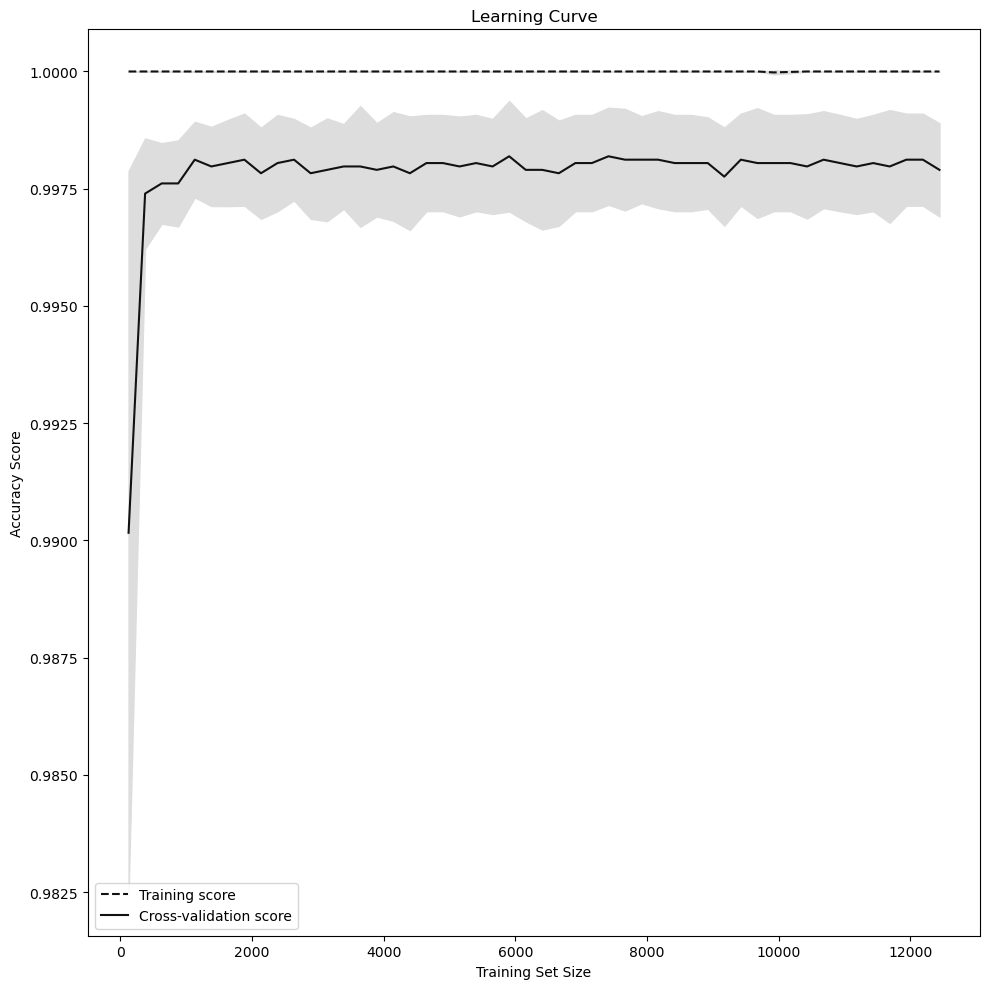

In [13]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [9]:
data.shape


(13823, 40)

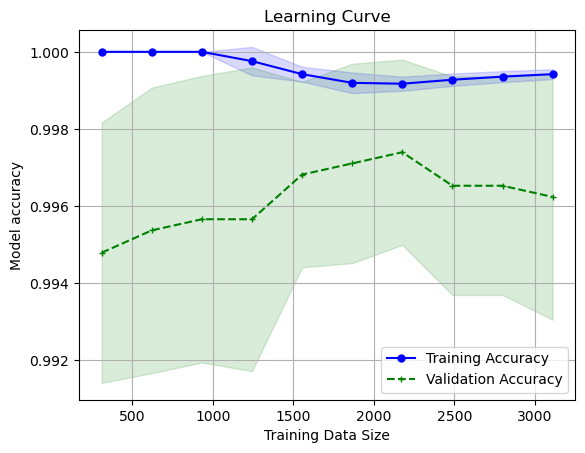

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, cell_type, test_size=0.75, stratify=cell_type, random_state=1)
#
# Create a pipeline; This will be passed as an estimator to learning curve method
#
pipeline = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, max_iter=10000))
#
# Use learning curve to get training and test scores along with train sizes
#
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()